In [1]:
import numpy as np
import cv2
from Utils.ImageUtils import *
from matplotlib import pyplot as plt
import math
from tqdm import *

K1 = np.array([[5299.313, 0, 1263.818], [0, 5299.313, 977.763], [0, 0, 1]])
K2 = np.array([[5299.313, 0, 1438.004], [0, 5299.313, 977.763], [0, 0, 1]])

In [2]:
def normalize(uv):
    """
    https://www.cc.gatech.edu/classes/AY2016/cs4476_fall/results/proj3/html/sdai30/index.html
    """
    uv_ = np.mean(uv, axis=0)
    u_,v_ = uv_[0], uv_[1]
    u_cap, v_cap = uv[:,0] - u_, uv[:,1] - v_

    s = (2/np.mean(u_cap**2 + v_cap**2))**(0.5)
    T_scale = np.diag([s,s,1])
    T_trans = np.array([[1,0,-u_],[0,1,-v_],[0,0,1]])
    T = T_scale.dot(T_trans)

    x_ = np.column_stack((uv, np.ones(len(uv))))
    x_norm = (T.dot(x_.T)).T

    return  x_norm, T

def EstimateFundamentalMatrix(feature_matches):
    normalised = True

    x1 = feature_matches[:,0:2]
    x2 = feature_matches[:,2:4]

    if x1.shape[0] > 7:
        if normalised == True:
            x1_norm, T1 = normalize(x1)
            x2_norm, T2 = normalize(x2)
        else:
            x1_norm,x2_norm = x1,x2
            
        A = np.zeros((len(x1_norm),9))
        for i in range(0, len(x1_norm)):
            x_1,y_1 = x1_norm[i][0], x1_norm[i][1]
            x_2,y_2 = x2_norm[i][0], x2_norm[i][1]
            A[i] = np.array([x_1*x_2, x_2*y_1, x_2, y_2*x_1, y_2*y_1, y_2, x_1, y_1, 1])

        U, S, VT = np.linalg.svd(A, full_matrices=True)
        F = VT.T[:, -1]
        F = F.reshape(3,3)

        u, s, vt = np.linalg.svd(F)
        s = np.diag(s)
        s[2,2] = 0
        F = np.dot(u, np.dot(s, vt))

        if normalised:
            F = np.dot(T2.T, np.dot(F, T1))
        return F

    else:
        return None

def errorF(feature, F): 
    """
    check the epipolar constraint
    """
    x1,x2 = feature[0:2], feature[2:4]
    x1tmp=np.array([x1[0], x1[1], 1]).T
    x2tmp=np.array([x2[0], x2[1], 1])

    error = np.dot(x1tmp, np.dot(F, x2tmp))
    
    return np.abs(error)

def meanErrorF(features, F):
    total_error = 0
    for n in range(features.shape[0]):
        feature = features[n, :]
        # x1,x2 = feature[3:5], feature[5:7]
        total_error = total_error + errorF(feature,F)

    mean_error = total_error / features.shape[0] 
    return mean_error


def getInliers(features):
    n_iterations = 1000
    error_thresh = 0.02
    inliers_thresh = 0
    chosen_indices = []
    chosen_f = 0

    for i in range(0, n_iterations):
        indices = []
        #select 8 points randomly
        n_rows = features.shape[0]
        random_indices = np.random.choice(n_rows, size=8)
        features_8 = features[random_indices, :] 
        f_8 = EstimateFundamentalMatrix(features_8)
        for j in range(n_rows):
            feature = features[j]
            error = errorF(feature, f_8)
            if error < error_thresh:
                indices.append(j)

        if len(indices) > inliers_thresh:
            inliers_thresh = len(indices)
            chosen_indices = indices
            chosen_f = f_8

    filtered_features = features[chosen_indices, :]
    return chosen_f, filtered_features

def getEssentialMatrix(K1, K2, F):
    E = K2.T.dot(F).dot(K1)
    U,s,V = np.linalg.svd(E)
    s = [1,1,0]
    E_ = np.dot(U,np.dot(np.diag(s),V))
    return E_

In [3]:
def getX(line, y):
    x = -(line[1]*y + line[2])/line[0]
    return x
    
def ExtractCameraPose(E):
    """
    Args:
        E (array): Essential Matrix
    Returns:
        arrays: set of Rotation and Camera Centers
    """

    ##UPDATE
    U, S, V_T = np.linalg.svd(E)
    W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])

    # print("E svd U", U)
    # print("E svd S", S)
    # print("E svd U[:, 2]", U[:, 2])
    R = []
    C = []
    R.append(np.dot(U, np.dot(W, V_T)))
    R.append(np.dot(U, np.dot(W, V_T)))
    R.append(np.dot(U, np.dot(W.T, V_T)))
    R.append(np.dot(U, np.dot(W.T, V_T)))
    C.append(U[:, 2])
    C.append(-U[:, 2])
    C.append(U[:, 2])
    C.append(-U[:, 2])

    for i in range(4):
        if (np.linalg.det(R[i]) < 0):
            R[i] = -R[i]
            C[i] = -C[i]

    return R, C


In [4]:
def getPositiveZCount(pts3D, R, C):
    P = np.dot(R, np.hstack((I, -C.reshape(3,1))))
    P = np.vstack((P, np.array([0,0,0,1]).reshape(1,4)))
    n_positiveZ = 0
    for i in range(pts3D.shape[1]):
        X = pts3D[:,i]
        X = X.reshape(4,1)
        Xc = np.dot(P, X)
        Xc = Xc / Xc[3]
        z = Xc[2]
        if z > 0:
            n_positiveZ += 1

    return n_positiveZ

Reading images from  /home/sakshi/courses/ENPM673/project3_sakshi/Data/Project 3/Dataset 2


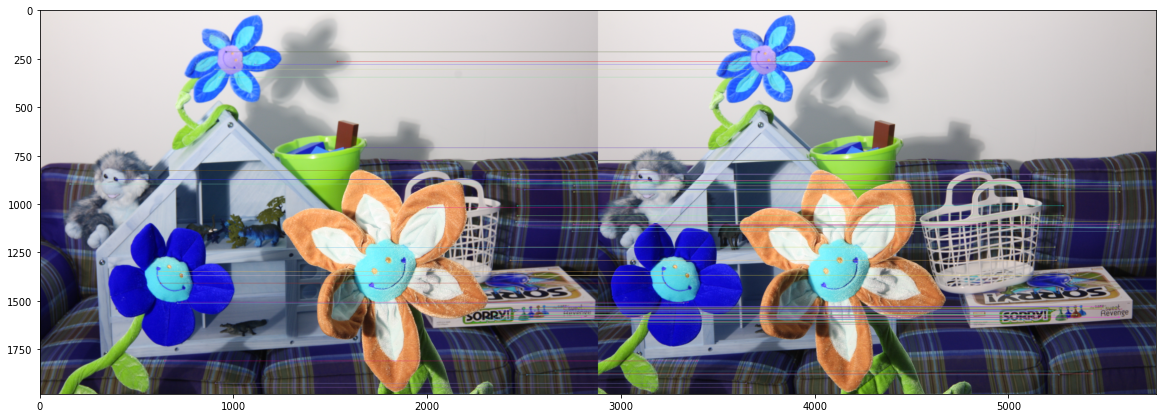

In [5]:
folder_name = "/home/sakshi/courses/ENPM673/project3_sakshi/Data/Project 3/Dataset 2"
images = readImageSet(folder_name, 2)
# find the keypoints and descriptors with SIFT
sift = cv2.xfeatures2d.SIFT_create()
image0 = images[0].copy()
image1 = images[1].copy()

image0_gray = cv2.cvtColor(image0, cv2.COLOR_BGR2GRAY) 
image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)


kp1, des1 = sift.detectAndCompute(image0_gray, None)
kp2, des2 = sift.detectAndCompute(image1_gray, None)

bf = cv2.BFMatcher()
matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x :x.distance)
chosen_matches = matches[0:100]

img3 = cv2.drawMatches(image0, kp1, image1, kp2, chosen_matches, images[0], flags=2)

plt.figure(figsize = (20,20))
plt.imshow(img3)



In [6]:

matched_pairs = []
for i, m1 in enumerate(chosen_matches):

    ## Notice: How to get the index
    pt1 = kp1[m1.queryIdx].pt
    pt2 = kp2[m1.trainIdx].pt
    matched_pairs.append([pt1[0], pt1[1], pt2[0], pt2[1]])
    # print(i, pt1,pt2 )
    ## Draw pairs in purple, to make sure the result is ok
    # cv2.circle(img1, (int(pt1[0]),int(pt1[1])), 10, (255,0,255), -1)
    # cv2.circle(img2, (int(pt2[0]),int(pt2[1])), 10, (255,0,255), -1)
matched_pairs = np.array(matched_pairs).reshape(-1, 4)

In [7]:
F_best, matched_pairs_inliers = getInliers(matched_pairs)
showMatches(image0, image1, matched_pairs_inliers, (0,0,255), "matches.png")
E = getEssentialMatrix(K1, K2, F_best)

In [8]:
# showMatches(image0, image1, matched_pairs_inliers, (0,0,255), "matches.png")

In [9]:
# E = getEssentialMatrix(K1, K2, F_best)

## Extract Pose

In [10]:
R2, C2 = ExtractCameraPose(E)

## Get 3D points


In [11]:
pts3D_4 = []
R1 = np.identity(3)
C1 = np.zeros((3,1))
I = np.identity(3)
P1 = np.dot(K1, np.dot(R1, np.hstack((I, -C1.reshape(3,1)))))

for i in range(len(C2)):
    pts3D = []
    x1 = matched_pairs_inliers[:,0:2].T
    x2 = matched_pairs_inliers[:,2:4].T

    P2 = np.dot(K2, np.dot(R2[i], np.hstack((I, -C2[i].reshape(3,1)))))

    X = cv2.triangulatePoints(P1, P2, x1, x2)  
    #X = X/X[3,:]
    pts3D_4.append(X)

## reproject 3D points on image

In [12]:
k = 3
P2 = np.dot(K2, np.dot(R2[k], np.hstack((I, -C2[k].reshape(3,1)))))
# P1 = np.dot(K1, np.dot(R1, np.hstack((I, -C1.reshape(3,1)))))

X = pts3D_4[k]
x_ = np.dot(P2, X)
x_ = x_/x_[2,:]

x = x_[0, :].T
y = x_[1, :].T

im = image1.copy()
for i in range(matched_pairs_inliers.shape[0]):

    x1, y1 = x[i], y[i]
    x2, y2 = matched_pairs_inliers[i, 2], matched_pairs_inliers[i, 3]
    cv2.circle(im, (int(x1), int(y1)), 10, (0,0,255), 10)
    cv2.circle(im, (int(x2), int(y2)), 3, (0,255,0), 3)

cv2.imshow("im", im)
cv2.waitKey() 
cv2.destroyAllWindows()

## plot 3D points and select R, C

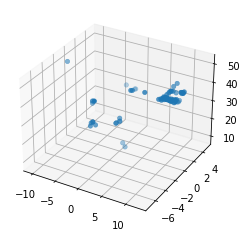

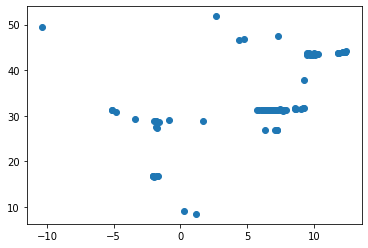

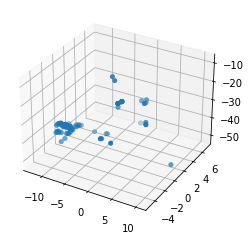

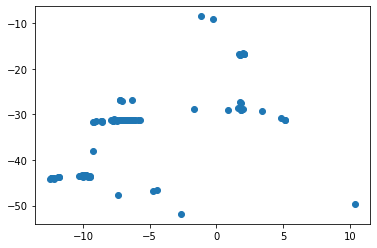

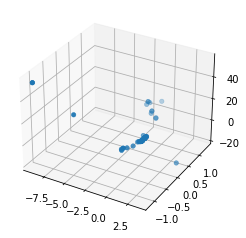

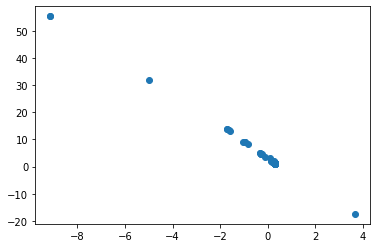

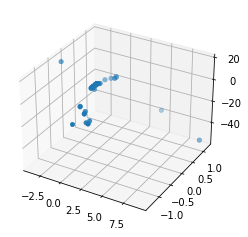

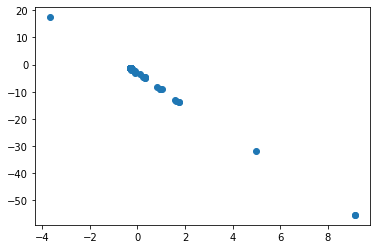

In [13]:
z_count1 = []
z_count2 = []

for i in range(len(pts3D_4)):
    pts3D = pts3D_4[i]
    pts3D = pts3D/pts3D[3, :]
    x = pts3D[0,:]
    y = pts3D[1, :]
    z = pts3D[2, :]    

    z_count2.append(getPositiveZCount(pts3D, R2[i], C2[i]))
    z_count1.append(getPositiveZCount(pts3D, R1, C1))

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter(x, y, z, linewidth=0.5)

    fig = plt.figure()
    plt.scatter(x,z)

z_count1 = np.array(z_count1)
z_count2 = np.array(z_count2)

count_thresh = int(pts3D_4[0].shape[1] / 2)
idx = np.intersect1d(np.where(z_count1 > count_thresh), np.where(z_count2 > count_thresh))
R2_ = R2[idx[0]]
C2_ = C2[idx[0]]
X_ = pts3D_4[idx[0]]
X_ = X_/X_[3,:]



## Plot epilines

In [14]:
set1, set2 = matched_pairs_inliers[:,0:2], matched_pairs_inliers[:,2:4]
lines1, lines2 = [], []
img_epi1 = image0.copy()
img_epi2 = image1.copy()

for i in range(set1.shape[0]):
    x1 = np.array([set1[i,0], set1[i,1], 1]).reshape(3,1)
    x2 = np.array([set2[i,0], set2[i,1], 1]).reshape(3,1)

    line2 = np.dot(F_best, x1)
    lines2.append(line2)

    line1 = np.dot(F_best.T, x2)
    lines1.append(line1)

    y2_min = 0
    y2_max = image1.shape[0]
    x2_min = getX(line2, y2_min)
    x2_max = getX(line2, y2_max)

    y1_min = 0
    y1_max = image0.shape[0]
    x1_min = getX(line1, y1_min)
    x1_max = getX(line1, y1_max)

    cv2.circle(img_epi2, (int(set2[i,0]),int(set2[i,1])), 10, (0,0,255), -1)
    img_epi2 = cv2.line(img_epi2, (int(x2_min), int(y2_min)), (int(x2_max), int(y2_max)), (0, 255,255), 1)
    

    cv2.circle(img_epi1, (int(set1[i,0]),int(set1[i,1])), 10, (0,0,255), -1)
    img_epi1 = cv2.line(img_epi1, (int(x1_min), int(y1_min)), (int(x1_max), int(y1_max)), (0, 255,255), 1)

image_1, image_2 = makeImageSizeSame([img_epi1, img_epi2])
concat = np.concatenate((image_1, image_2), axis = 1)
concat = cv2.resize(concat, (1920, 660))
cv2.imshow("a", concat)
cv2.imwrite("epilines.png", concat)
cv2.waitKey()
cv2.destroyAllWindows()



## Image Rectification

In [15]:
r1 = (C2_/ np.linalg.norm(C2_, 2)).reshape(1,3)
cross = np.array([-C2_[1], C2_[0], 0]).reshape(1,3)
r2 = cross / np.sqrt(C2_[1] **2 + C2_[0]**2)
r3 = np.cross(r1, r2)
R_rect = np.vstack((r1, r2, r3)).reshape(3,3)

In [16]:
# Stereo rectification (uncalibrated variant)
# Adapted from: https://stackoverflow.com/a/62607343
h1, w1 = image0.shape[:2]
h2, w2 = image1.shape[:2]
_, H1, H2 = cv2.stereoRectifyUncalibrated(np.float32(set1), np.float32(set2), F_best, imgSize=(w1, h1))

# Undistort (rectify) the images and save them
# Adapted from: https://stackoverflow.com/a/62607343
img1_rectified = cv2.warpPerspective(image0, H1, (w1, h1))
img2_rectified = cv2.warpPerspective(image1, H2, (w2, h2))

set1_rectified = cv2.perspectiveTransform(set1.reshape(-1, 1, 2), H1).reshape(-1,2)
set2_rectified = cv2.perspectiveTransform(set2.reshape(-1, 1, 2), H2).reshape(-1,2)

cv2.imwrite("rectified_1.png", img1_rectified)
cv2.imwrite("rectified_2.png", img2_rectified)

img1_rectified_draw = img1_rectified.copy()
img2_rectified_draw = img2_rectified.copy()

for i in range(set1_rectified.shape[0]):
    cv2.circle(img1_rectified_draw, (int(set1_rectified[i,0]),int(set1_rectified[i,1])), 10, (0,0,255), -1)
    cv2.circle(img2_rectified_draw, (int(set2_rectified[i,0]),int(set2_rectified[i,1])), 10, (0,0,255), -1)

cv2.imshow("a", img1_rectified_draw)
cv2.waitKey() 
cv2.imshow("a", img2_rectified_draw)
cv2.waitKey() 

cv2.destroyAllWindows()


## get rectified epilines

In [17]:
H2_T_inv =  np.linalg.inv(H2.T)
H1_inv = np.linalg.inv(H1)
F_rectified = np.dot(H2_T_inv, np.dot(F_best, H1_inv))

# img2_rectified_draw = img2_rectified.copy()
# img1_rectified_draw = img1_rectified.copy()

rectified_lines1, rectified_lines2 = [], []
for i in range(set1_rectified.shape[0]):
    x1 = np.array([set1_rectified[i,0], set1_rectified[i,1], 1]).reshape(3,1)
    x2 = np.array([set2_rectified[i,0], set2_rectified[i,1], 1]).reshape(3,1)

    rectified_line2 = np.dot(F_rectified, x1)
    rectified_lines2.append(rectified_line2)

    rectified_line1 = np.dot(F_rectified.T, x2)
    rectified_lines1.append(rectified_line1)

    x2_min = 0
    x2_max = image1.shape[1] - 1
    y2_min = -rectified_line2[2]/rectified_line2[1]
    y2_max = -rectified_line2[2]/rectified_line2[1]

    x1_min = 0
    x1_max = image0.shape[1] -1
    y1_min = -rectified_line1[2]/rectified_line1[1]
    y1_max = -rectified_line1[2]/rectified_line1[1]

    cv2.circle(img2_rectified_draw, (int(set2_rectified[i,0]),int(set2_rectified[i,1])), 10, (255,0,0), -1)
    img2_rectified_draw = cv2.line(img2_rectified_draw, (int(x2_min), int(y2_min)), (int(x2_max), int(y2_max)), (255, 0, int(i*2.55)), 2)
    # if (y2_min >= img2.shape[1]) or (y1_min >= img1.shape[1]):
    #     print(y2_min, y1_min)
    

    cv2.circle(img1_rectified_draw, (int(set1_rectified[i,0]),int(set1_rectified[i,1])), 10, (255,0,0), -1)
    img1_rectified_draw = cv2.line(img1_rectified_draw, (int(x1_min), int(y1_min)), (int(x1_max), int(y1_max)), (255, 0, int(i*2.55) ), 2)
    # img1_rectified = cv2.line(img1_rectified, (int(x2_min), int(y2_min)), (int(x2_max), int(y2_max)), (255, 0, 0), 1)

    
image_1, image_2 = makeImageSizeSame([img1_rectified_draw, img2_rectified_draw])
concat = np.concatenate((image_1, image_2), axis = 1)
concat = cv2.resize(concat, (1920, 660))
cv2.imshow("a", concat)
cv2.waitKey()
cv2.destroyAllWindows()


## Find Correspondance

In [19]:
def SSD(mat1, mat2):
    diff_sq = np.square(mat1 - mat2)
    ssd = np.sum(diff_sq)
    return ssd

def SAD(mat1, mat2):
    return np.sum(abs(mat1 - mat1))

def NCC(patch1, patch2):
  patch1_hat, patch2_hat = patch1 - patch1.mean(), patch2 - patch2.mean()
  upper = np.sum(patch1_hat*patch2_hat)
  lower = np.sqrt(np.sum(patch1_hat*patch1_hat)*np.sum(patch2_hat*patch2_hat))
  return upper/lower



In [20]:
search_distance = 50
img1_rectified_reshaped = cv2.resize(img1_rectified, (int(img1_rectified.shape[1] / 4), int(img1_rectified.shape[0] / 4)))
img2_rectified_reshaped = cv2.resize(img2_rectified, (int(img2_rectified.shape[1] / 4), int(img2_rectified.shape[0] / 4)))

img1_rectified_reshaped = cv2.cvtColor(img1_rectified_reshaped, cv2.COLOR_BGR2GRAY)
img2_rectified_reshaped = cv2.cvtColor(img2_rectified_reshaped, cv2.COLOR_BGR2GRAY)


In [20]:
h, w = img1_rectified_reshaped.shape[:2]
disparity = np.zeros((h, w), np.uint8)
window_size = 10
half_window_size = math.floor((window_size)/2)

for y in tqdm(range(half_window_size, h - half_window_size)):#, h -  half_window_size)): 
    for x in range(half_window_size + search_distance , w - half_window_size - search_distance): #w -  half_window_size):

        patch1 = img1_rectified_reshaped[y - half_window_size: y + half_window_size, x - half_window_size : x + half_window_size]
        min_ssd = 10000
        dispar = 0
        max_ncc = 0
        # #scan along epiline till a particular length
        for distance in range(-search_distance, search_distance, 1): #bidirectional
            x_dash = x + distance
            # if (x_dash < w - half_window_size) and (x_dash > half_window_size):
            patch2 = img2_rectified_reshaped[y - half_window_size: y + half_window_size, x_dash - half_window_size : x_dash + half_window_size]
            ncc = NCC(patch1, patch2)
            if ncc > max_ncc:
                max_ncc = ncc
                dispar = np.abs(distance)
        
        disparity[y, x] = dispar
        

  2%|▏         | 10/485 [00:19<15:38,  1.98s/it]


KeyboardInterrupt: 

In [22]:
BLOCK_SIZE = 11
SEARCH_BLOCK_SIZE = 76


In [ ]:
BLOCK_SIZE = 11
SEARCH_BLOCK_SIZE = 76

def sum_of_abs_diff(pixel_vals_1, pixel_vals_2):
    if pixel_vals_1.shape != pixel_vals_2.shape:
        return -1

    return np.sum(abs(pixel_vals_1 - pixel_vals_2))


def compare_blocks(y, x, block_left, right_array, block_size=5):
    """
    Compare left block of pixels with multiple blocks from the right
    image using SEARCH_BLOCK_SIZE to constrain the search in the right
    image.
    Args:
        y (int): row index of the left block
        x (int): column index of the left block
        block_left (numpy.ndarray): containing pixel values within the 
                    block selected from the left image
        right_array (numpy.ndarray]): containing pixel values for the 
                     entrire right image
        block_size (int, optional): Block of pixels width and height. 
                                    Defaults to 5.
    Returns:
        tuple: (y, x) row and column index of the best matching block 
                in the right image
    """
    # Get search range for the right image
    x_min = max(0, x - SEARCH_BLOCK_SIZE)
    x_max = min(right_array.shape[1], x + SEARCH_BLOCK_SIZE)
    #print(f'search bounding box: ({y, x_min}, ({y, x_max}))')
    first = True
    min_sad = None
    min_index = None
    for x in range(x_min, x_max):
        block_right = right_array[y: y+block_size,
                                  x: x+block_size]
        sad = sum_of_abs_diff(block_left, block_right)
        #print(f'sad: {sad}, {y, x}')
        if first:
            min_sad = sad
            min_index = (y, x)
            first = False
        else:
            if sad < min_sad:
                min_sad = sad
                min_index = (y, x)

    return min_index



def get_disparity_map():
    left_array, right_array = img1_rectified_reshaped, img2_rectified_reshaped
    left_array = left_array.astype(int)
    right_array = right_array.astype(int)
    if left_array.shape != right_array.shape:
        raise "Left-Right image shape mismatch!"
    h, w = left_array.shape
    # left_im = cv2.imread("data/left.png", 0)
    disparity_map = np.zeros((h, w))
    # Go over each pixel position
    for y in tqdm(range(BLOCK_SIZE, h-BLOCK_SIZE)):
        for x in range(BLOCK_SIZE, w-BLOCK_SIZE):
            block_left = left_array[y:y + BLOCK_SIZE,
                                    x:x + BLOCK_SIZE]
            min_index = compare_blocks(y, x, block_left,
                                       right_array,
                                       block_size=BLOCK_SIZE)
            disparity_map[y, x] = abs(min_index[1] - x)
            # Debug section to visualize the blocks on the image
            # left_im_bbox = cv2.rectangle(left_im, (x, y),
            #                              (x + 25, y + 25),
            #                              (0, 0, 255), 2)
            # display_image(left_im_bbox, window_name='left')
            # print(left_array[y:y+25, x:x+25])
            # right_image_block(x, y)

    print(disparity_map)
    plt.imshow(disparity_map, cmap='hot', interpolation='nearest')
    plt.savefig('depth_image.png')
    plt.show()
    # img = Image.fromarray(disparity_map, 'L')
    # img.show()


if __name__ == '__main__':
    get_disparity_map()

In [23]:

left_array, right_array = img1_rectified_reshaped, img2_rectified_reshaped
left_array = left_array.astype(int)
right_array = right_array.astype(int)
if left_array.shape != right_array.shape:
    raise "Left-Right image shape mismatch!"
h, w = left_array.shape
disparity_map = np.zeros((h, w))


# Go over each pixel position
for y in range(1):
    block_left_array = []
    block_right_array = []
    for x in range(BLOCK_SIZE, w-BLOCK_SIZE):
        block_left = left_array[y:y + BLOCK_SIZE,
                                x:x + BLOCK_SIZE]
        block_left_array.append(block_left.flatten())

        block_right = right_array[y:y + BLOCK_SIZE,
                                x:x + BLOCK_SIZE]
        block_right_array.append(block_right.flatten())


    block_left_array = np.array(block_left_array)
    block_left_array = np.repeat(block_left_array[:, :, np.newaxis], 698, axis=2)

    block_right_array = np.array(block_right_array)
    block_right_array = np.repeat(block_right_array[:, :, np.newaxis], 698, axis=2)
    block_right_array = block_right_array.T

    abs_diff = np.abs(block_left_array - block_right_array)
    sum_abs_diff = np.sum(abs_diff, axis = 1)
    idx = np.argmin(sum_abs_diff, axis = 0)
    disparity = np.abs(idx - np.linspace(0, 698, 698, dtype=int)).reshape(1, 698)
    disparity_map[y, 0:698] = disparity 






In [25]:
abs_diff = np.abs(block_left_array - block_right_array)
sum_abs_diff = np.sum(abs_diff, axis = 1)

In [26]:
sum_abs_diff.shape

(698, 698)

In [27]:
idx = np.argmin(sum_abs_diff, axis = 0)

In [31]:
np.abs(idx - np.linspace(0, 698, 698)).astype(int)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121,  38,  38,  38,  38,  37,  37,  37,  37,
        37,  37,  37,  37,  37,  37,  37,  37,  36,  36,  36,  36,  35,
        34,  34,  34,  34,  34,  34,  34,  33,  33,  33,  33,  33,  33,
        33,  33,  33,  33,  32,  32,  31,  30,  30,  30,  30,  30,  30,
        30,  30,  30,  30,  29,  29,  29,  29,  29,  29,  29,  2

In [99]:
idx

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,  11,  10,  11,  10,
        11,  11,  11,  11,  11,  11,  19,  28,  29,  30,  31,  32,  29,
        31,  32,  32,  31,  32,  32,  32,  32,  32,  32,  32,  32,  32,
        32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,
        32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,
        32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,
        32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,
        32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,
        32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  33,
        34,  35,  36,  37,  39,  40,  41,  43,  44,  46,  47,  49,  50,
        52,  53,  55,  57,  58,  59,  61,  63,  64,  66,  67,  6

## Test

In [41]:
block_left_array.shape

(698, 11, 11)

In [55]:
img1_rectified_reshaped = cv2.cvtColor(img1_rectified_reshaped, cv2.COLOR_BGR2GRAY)
img2_rectified_reshaped = cv2.cvtColor(img2_rectified_reshaped, cv2.COLOR_BGR2GRAY)


In [56]:
def sum_of_abs_diff(pixel_vals_1, pixel_vals_2):
    if pixel_vals_1.shape != pixel_vals_2.shape:
        return -1

    return np.sum(abs(pixel_vals_1 - pixel_vals_2))

In [57]:
disparity_map = np.zeros((h, w))

In [58]:
BLOCK_SIZE = 7
SEARCH_BLOCK_SIZE = 56

def compare_blocks(y, x, block_left, right_array, block_size=5):
    # Get search range for the right image
    x_min = max(0, x - SEARCH_BLOCK_SIZE)
    x_max = min(right_array.shape[1], x + SEARCH_BLOCK_SIZE)
    #print(f'search bounding box: ({y, x_min}, ({y, x_max}))')
    first = True
    min_sad = None
    min_index = None
    for x in range(x_min, x_max):
        block_right = right_array[y: y+block_size,
                                  x: x+block_size]
        sad = sum_of_abs_diff(block_left, block_right)
        #print(f'sad: {sad}, {y, x}')
        if first:
            min_sad = sad
            min_index = (y, x)
            first = False
        else:
            if sad < min_sad:
                min_sad = sad
                min_index = (y, x)

    return min_index

In [59]:
from tqdm import *

In [60]:
for y in tqdm(range(BLOCK_SIZE, h-BLOCK_SIZE)):
        for x in range(BLOCK_SIZE, w-BLOCK_SIZE):
            block_left = img1_rectified_reshaped[y:y + BLOCK_SIZE,
                                    x:x + BLOCK_SIZE]
            min_index = compare_blocks(y, x, block_left,
                                       img2_rectified_reshaped,
                                       block_size=BLOCK_SIZE)
            disparity_map[y, x] = abs(min_index[1] - x)

100%|██████████| 646/646 [07:23<00:00,  1.46it/s]


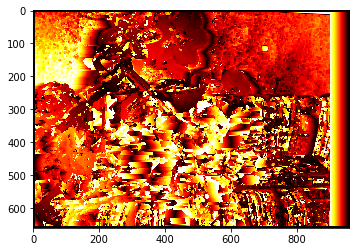

In [63]:
plt.imshow(disparity_map, cmap='hot', interpolation='nearest')
plt.savefig('depth_image.png')
plt.show()

In [26]:
# def drawlines(img1,img2,lines,pts1,pts2):
#     ''' img1 - image on which we draw the epilines for the points in img2
#         lines - corresponding epilines '''
#     r,c = img1.shape[:2]
#     # img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
#     # img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
#     for r,pt1,pt2 in zip(lines,pts1,pts2):
#         color = tuple(np.random.randint(0,255,3).tolist())
#         x0,y0 = map(int, [0, -r[2]/r[1] ])
#         x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
#         img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
#         img1 = cv2.circle(img1,tuple(np.int32(pt1)),5,color,-1)
#         img2 = cv2.circle(img2,tuple(np.int32(pt2)),5,color,-1)
#     return img1,img2

In [34]:
# img2 = images[1].copy()
# lines2 = cv2.computeCorrespondEpilines(set1.reshape(-1,1,2), 2, F_best)
# lines2 = lines2.reshape(-1,3)
# img2,img1 = drawlines(img2,img1,lines2,set2,set1)
# cv2.imwrite("epilines2.png", img2)

True